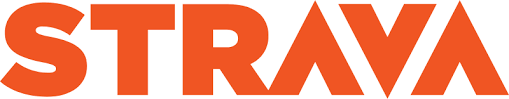

# Strava Performance Report

Latest update: November 28, 2021

This report leverages Strava's Developer API to generate analyses on biking data collected through workout streaming via the Strava mobile app. For more information on the Strava API, please see the [API documentation](https://developers.strava.com/docs/getting-started/). Additionally, this [Medium article](https://medium.com/swlh/using-python-to-connect-to-stravas-api-and-analyse-your-activities-dummies-guide-5f49727aac86) provides a more detailed description of how to access and use the Strava API.

In [1]:
import pandas as pd
import requests
import time
from datetime import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress
import warnings

warnings.filterwarnings("ignore")

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Personal data was hidden from this report, but to replicate, access the Strava API page, create a new application and input authentification code, client ID, and client secret below. The authentification code has a limited useable time period, so it will likely need to be updated often. Refer to Strava API documentation for instructions on how to do this.

In [3]:
#auth_code = AUTH_CODE_HIDDEN
#client_id = CLIENT_ID_HIDDEN
#client_secret = CLIENT_SECRET_HIDDEN

The 'get_activities' function created below will return a dataframe of data from the Strava user associated with parameter inputs. Please note, the function does not incorporate every data point available from Strava's API.

In [4]:
def get_activities(auth_code, client_id, client_secret):
    
    # Make Strava auth API call with your client_code, client_secret and code
    response = requests.post(
                        url = 'https://www.strava.com/oauth/token',
                        data = {
                                'client_id': client_id,
                                'client_secret': client_secret,
                                'code': auth_code,
                                'grant_type': 'authorization_code'
                                })
    
    strava_tokens = response.json()
        
    ## If access_token has expired then use the refresh_token to get the new access_token
    if strava_tokens['expires_at'] < time.time():
    #Make Strava auth API call with current refresh token
        response = requests.post(
                            url = 'https://www.strava.com/oauth/token',
                            data = {
                                    'client_id': client_id,
                                    'client_secret': client_secret,
                                    'grant_type': 'refresh_token',
                                    'refresh_token': strava_tokens['refresh_token']
                                    })
        
        # Save response as json in new variable
        new_strava_tokens = response.json()
            
        #Use new Strava tokens from now
        strava_tokens = new_strava_tokens
        
    #Loop through all activities
    page = 1
    url = "https://www.strava.com/api/v3/activities"
    access_token = strava_tokens['access_token']
    
    ## Create the dataframe ready for the API call to store your activity data
    activities = pd.DataFrame(
        columns = [
                "id",
                "name",
                "start_date_local",
                "type",
                "distance",
                "moving_time",
                "elapsed_time",
                "total_elevation_gain",
                "start_latitude",
                "start_longitude",
                "workout_type",
                "average_speed",
                "max_speed"])
    
    while True:
        
        # get page of activities from Strava
        r = requests.get(url + '?access_token=' + access_token + '&per_page=200' + '&page=' + str(page))
        r = r.json()
        
        # if no results then exit loop
        if (not r):
            break
        
        # otherwise add new data to dataframe
        for x in range(len(r)):
            activities.loc[x + (page-1)*200,'id'] = r[x]['id']
            activities.loc[x + (page-1)*200,'name'] = r[x]['name']
            activities.loc[x + (page-1)*200,'start_date_local'] = r[x]['start_date_local']
            activities.loc[x + (page-1)*200,'type'] = r[x]['type']
            activities.loc[x + (page-1)*200,'distance'] = r[x]['distance']
            activities.loc[x + (page-1)*200,'moving_time'] = r[x]['moving_time']
            activities.loc[x + (page-1)*200,'elapsed_time'] = r[x]['elapsed_time']
            activities.loc[x + (page-1)*200,'total_elevation_gain'] = r[x]['total_elevation_gain']
            activities.loc[x + (page-1)*200,'start_latitude'] = r[x]['start_latitude']
            activities.loc[x + (page-1)*200,'start_longitude'] = r[x]['start_longitude']
            activities.loc[x + (page-1)*200,'workout_type'] = r[x]['workout_type']
            activities.loc[x + (page-1)*200,'average_speed'] = r[x]['average_speed']
            activities.loc[x + (page-1)*200,'max_speed'] = r[x]['max_speed']
            
        # increment page
        page += 1
        
    return(activities)

In [5]:
activities = get_activities(auth_code, client_id, client_secret)
activities.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,start_latitude,start_longitude,workout_type,average_speed,max_speed
0,6319244383,Thanksgiving burn off,2021-11-28T13:04:26Z,Ride,20399.5,4010,4313,104.7,32.794929,-96.796510,11,5.087,9.916
1,6277258601,Haircut after 3 weeks on the road,2021-11-18T19:15:20Z,Ride,3716.1,947,1603,7.4,32.794817,-96.796944,12,3.924,10.030
2,6189598941,Last ride beforehand busy November,2021-10-30T17:30:41Z,Ride,13164.2,2577,5819,55.7,32.794822,-96.796438,11,5.108,9.006
3,6089983858,First ride with Cyn!,2021-10-09T11:03:38Z,Ride,13641.4,3648,5360,59.0,32.794422,-96.797349,10,3.739,12.000
4,6019608598,Night Ride,2021-09-25T19:18:12Z,Ride,12230.3,3115,3768,60.2,32.794697,-96.796575,12,3.926,10.700


In [6]:
# Convert numeric variables to float types
activities[["distance", 
            "moving_time", 
            "elapsed_time", 
            "total_elevation_gain", 
            "start_latitude", 
            "start_longitude", 
            "average_speed", 
            "max_speed"]] = activities[["distance", 
                                        "moving_time", 
                                        "elapsed_time", 
                                        "total_elevation_gain", 
                                        "start_latitude", 
                                        "start_longitude", 
                                        "average_speed", 
                                        "max_speed"]].astype(float)

In [7]:
# Clean existing fields, derive new fields
activities['start_date_local'] = activities['start_date_local'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

activities['month'] = activities['start_date_local'].apply(lambda x: x.strftime('%b'))
activities['year_month'] = activities['start_date_local'].apply(lambda x: x.strftime('%Y%m'))
activities['year_month'] = activities['year_month'].apply(str)

activities['hour_of_day'] = activities['start_date_local'].apply(lambda x: x.hour)
activities['time_of_day'] = activities['hour_of_day'].apply(lambda x: "Morning" if x < 12 else "Afternoon" if x < 17 else "Evening")

activities['distance_miles'] = activities['distance']/1609
activities['moving_time_hr'] = activities['moving_time']/3600
activities['elapsed_time_hr'] = activities['elapsed_time']/3600
activities['ride_time_share'] = activities['moving_time_hr']/activities['elapsed_time_hr']
    
activities['workout_type'] = activities['workout_type'].apply(lambda x: "Workout" if x == 11 else "Casual")

In [8]:
# Remove unnecessary columns
activities = activities[['id', 'year_month', 'month', 'hour_of_day', 'time_of_day', 'type', 
                         'distance_miles', 'moving_time_hr', 'elapsed_time_hr', 'ride_time_share', 
                         'total_elevation_gain', 'start_latitude', 'start_longitude', 'workout_type', 
                         'average_speed', 'max_speed']]
activities.head()

,id,year_month,month,hour_of_day,time_of_day,type,distance_miles,moving_time_hr,elapsed_time_hr,ride_time_share,total_elevation_gain,start_latitude,start_longitude,workout_type,average_speed,max_speed
0,6319244383,202111,Nov,13,Afternoon,Ride,12.678372,1.113889,1.198056,0.929747,104.7,32.794929,-96.796510,Workout,5.087,9.916
1,6277258601,202111,Nov,19,Evening,Ride,2.309571,0.263056,0.445278,0.590767,7.4,32.794817,-96.796944,Casual,3.924,10.030
2,6189598941,202110,Oct,17,Evening,Ride,8.181603,0.715833,1.616389,0.442860,55.7,32.794822,-96.796438,Workout,5.108,9.006
3,6089983858,202110,Oct,11,Morning,Ride,8.478185,1.013333,1.488889,0.680597,59.0,32.794422,-96.797349,Casual,3.739,12.000
4,6019608598,202109,Sep,19,Evening,Ride,7.601181,0.865278,1.046667,0.826699,60.2,32.794697,-96.796575,Casual,3.926,10.700


### Total Performance
Total miles and number of rides by month

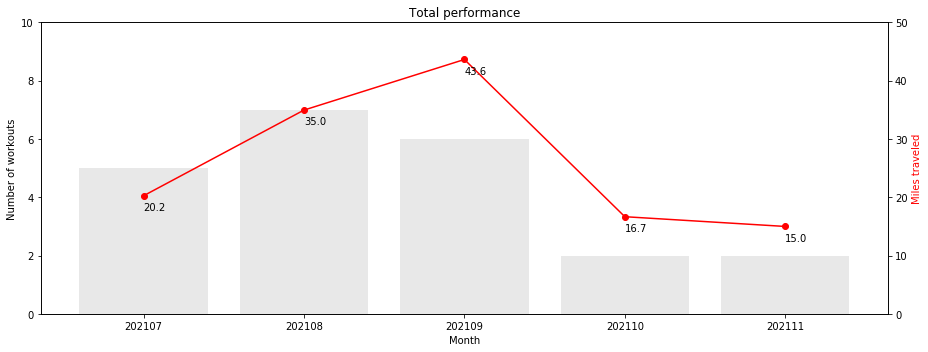

In [9]:
total_bar_line = activities.groupby(['year_month']).agg({'distance_miles':'sum', 'id':'count'}).reset_index()

fig, ax = plt.subplots(figsize = (13, 5))
plt.title('Total performance')

ax2 = ax.twinx()
ax.bar("year_month", "id", data = total_bar_line, alpha=0.5, color = 'lightgrey')
ax2.plot("year_month", "distance_miles", data = total_bar_line, marker = 'o', color = 'r')

ax.set_xlabel('Month')
ax.set_ylabel('Number of workouts')
ax2.set_ylabel('Miles traveled', color = 'r')

for i, dist in enumerate(total_bar_line['distance_miles']):
    plt.annotate(round(dist, 1),(total_bar_line['year_month'][i], total_bar_line['distance_miles'][i]-2.5))

ax.set_ylim (0, 10)
ax2.set_ylim (0, 50)

plt.tight_layout()
plt.show()

### Favorite times of day
Moving time by time of day over time

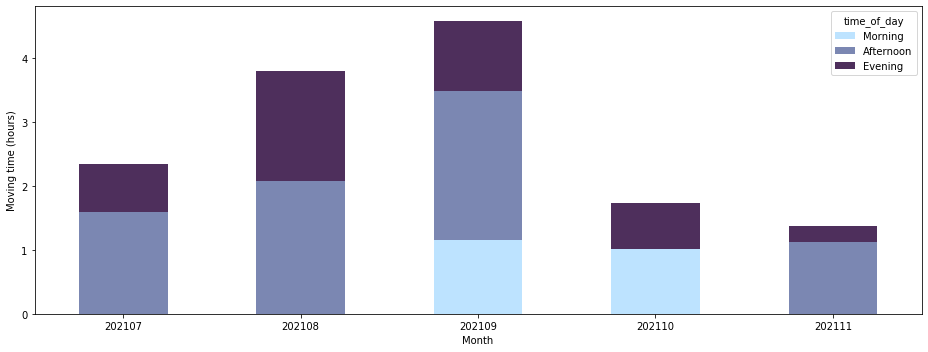

In [10]:
ride_time = activities[['year_month', 'workout_type', 'moving_time_hr', 'time_of_day']]

ride_time = ride_time.groupby(['year_month', 'time_of_day']).agg({'moving_time_hr':'sum'}).reset_index()
ride_time_pivot = ride_time.pivot(index='year_month', columns='time_of_day', values='moving_time_hr')

colors = ["#bde3ff", "#7b87b2","#4e2f5c"]

plot = ride_time_pivot.loc[:,['Morning','Afternoon', 'Evening']].plot.bar(stacked=True, color=colors, figsize=(13,5))

plot.set_xlabel('Month')
plot.set_ylabel('Moving time (hours)')
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show()

### Working out more or commuting more?
Share of miles completed via workout by month

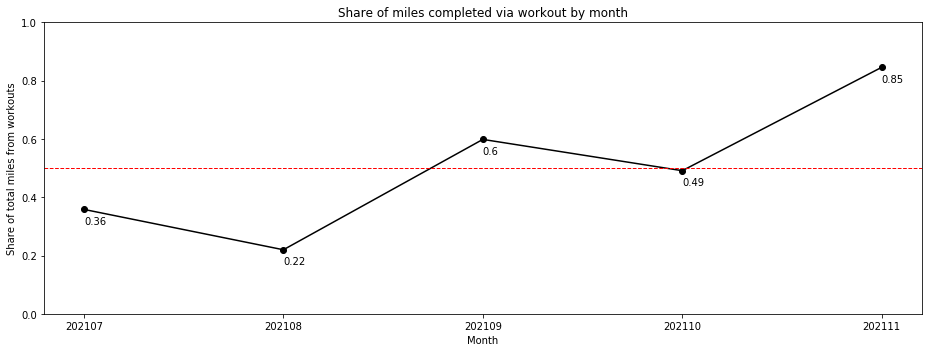

In [11]:
miles_share = activities.groupby(['year_month', 'workout_type']).agg({'distance_miles':'sum'}).reset_index()
miles_share = miles_share.pivot(index='year_month', columns='workout_type', values='distance_miles').reset_index()
miles_share['workout_share'] = miles_share['Workout']/(miles_share['Casual']+miles_share['Workout'])

fig, ax = plt.subplots(figsize = (13, 5))
plt.title('Share of miles completed via workout by month')

ax.plot("year_month", "workout_share", data = miles_share, marker = 'o', color = 'black')
plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth = 1)

ax.set_xlabel('Month')
ax.set_ylabel('Share of total miles from workouts')

ax.set_ylim (0, 1)

for i, dst in enumerate(miles_share['workout_share']):
    plt.annotate(round(dst, 2),(miles_share['year_month'][i], miles_share['workout_share'][i]-0.05))

plt.tight_layout()
plt.show()

### Effect of ride length on average speed in workouts

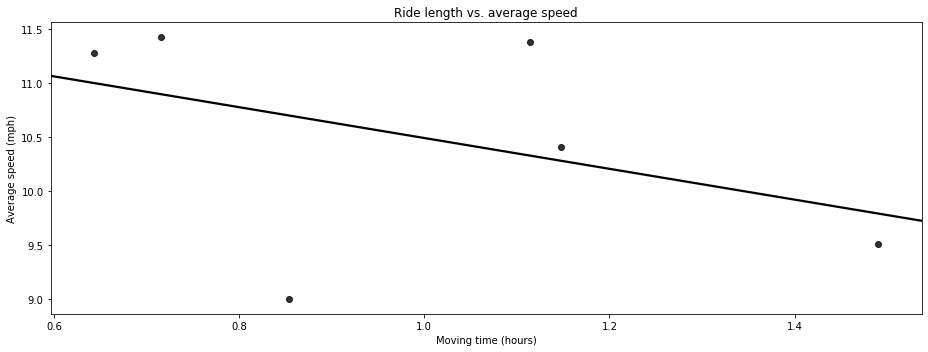

Average speed tends to decreases as ride length increases
For every additional 30 minutes of riding, average speed is expected to change by -0.7 mph


However, the relationship between ride length and average speed (as indicated by a p value of 0.39) does not pass the 80% confidence level, so this analysis is not trustworthy proof of a relationship


In [12]:
time_speed_plot = activities
time_speed_plot['average_speed_mph'] = time_speed_plot['distance_miles']/time_speed_plot['moving_time_hr']
time_speed_plot = activities[activities['workout_type'] == "Workout"]

fig, ax = plt.subplots(figsize = (13, 5))
plt.title('Ride length vs. average speed')

ax = sns.regplot(x="moving_time_hr", y="average_speed_mph", data=time_speed_plot, ci=None, color = "black")

ax.set_xlabel('Moving time (hours)')
ax.set_ylabel('Average speed (mph)')

plt.tight_layout()
plt.show()

# ==========

trendline_results = linregress(time_speed_plot['moving_time_hr'],time_speed_plot['average_speed_mph'])

slope = trendline_results.slope
rvalue = trendline_results.rvalue
pvalue = trendline_results.pvalue

if rvalue < 0:
    direction = "decreases"
elif rvalue > 0:
    direction = "increases"
else:
    direction = "randomly increase or decrease"

print("Average speed tends to " + direction + " as ride length increases")
print("For every additional 30 minutes of riding, average speed is expected to change by " + str(round(slope/2, 1)) + " mph")
print("\n")

if pvalue > 0.2:
    print("However, the relationship between ride length and average speed (as indicated by a p value of " 
          + str(round(pvalue, 2)) + ") does not pass the 80% confidence level, so this analysis is not trustworthy proof of a relationship")